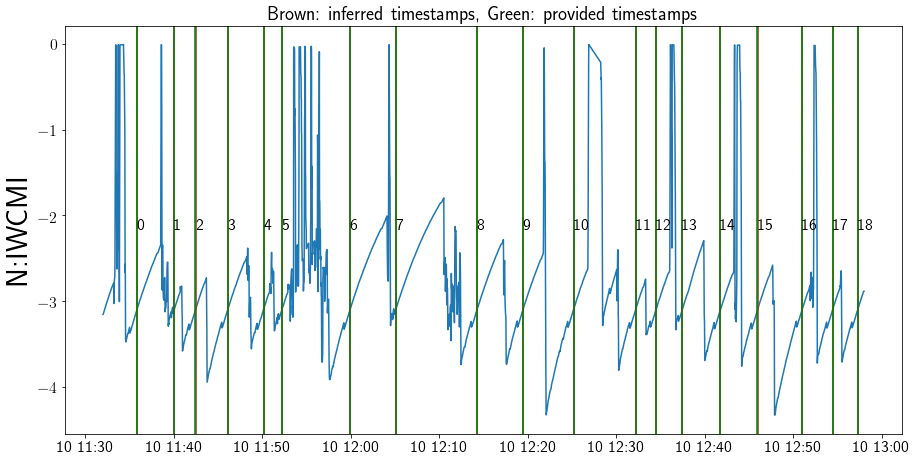

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [65]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
from fur.path_assistant import PathAssistant
shift = PathAssistant('shift_03_10_2020',      
    ignore_files=["RefCurve_2020-03-10_0_111937_test.Wfm.bin"])
results_dir = shift.get_results_dir()
bpm_files_df = shift.get_bpm_files_df()
timestamps = bpm_files_df["file_datetime"].apply(lambda t: t.round(freq='S'))[1:]
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data
fluctuations_df = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_nd_filters_data_03_10_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.3.6ds_data.txt",
    provided_timestamps=timestamps,
    show_plot=True
)
from config import get_from_config, save_to_config
import json
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy

from fur.jsonstorage import JsonStorage
js10 = JsonStorage(shift.get_results_dir().fi('jsonstorage_03_10_2020.json'))

In [66]:
desc = fluctuations_df.describe()
desc

,ch2_amplitude,var_of_ch1_amplitude,noise_var,var_of_ch1_amplitude_err,noise_var_err,N:IWCMI,N:IBEAMA,N:IWCMBE,N:IWCMBR,N:IWCMBF,N:IWCMBG,N:IRFEPA,N:ITC1RSH,N:ITC2RSH,N:ITC3RSH,N:ITC4RSH,N:ITC4LSH,N:ITC3LSH,N:ITC2LSH,N:ITC1LSH,N:ITC1RSV,N:ITC2RSV,N:ITC3RSV,N:ITC4RSV,N:ITC4LSV,N:ITC3LSV,N:ITC2LSV,N:ITC1LSV,N:IWCMI_recalibrated_to_IWCMI_absolute,N:IBEAM_recalibrated_to_IWCMI_absolute,Sigma_um_X,Sigma_um_X_err,Sigma_um_Y,Sigma_um_Y_err,Angle_spread_rad_X,Angle_spread_rad_Y,ex_um,ex_err,ey_um,ey_err,dp/p,dp/p_err
count,19.000000,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0
mean,0.306173,1.825778e-08,8.679781e-08,1.451799e-10,5.112121e-11,-3.101046,-2.834816,29.496419,31.904693,64.245359,28.090796,382.245298,481.748188,1453.995658,1679.299200,7.327710e+02,1103.675418,1684.906068,1592.881008,514.511205,118.851636,82.495185,98.920255,105.9989,167.087819,76.374799,73.138058,141.714046,-2.743075,-2.740521,1194.702335,19.330692,93.954513,7.423908,0.000943,0.000127,0.659192,0.022684,0.008972,0.001417,0.000288,0.0
std,0.162183,1.362985e-08,8.470340e-10,2.996995e-11,1.060343e-11,0.005150,0.018760,0.203873,0.241050,0.295263,0.175942,0.142068,4.737316,15.531610,17.480483,1.168021e-13,11.197518,18.908706,16.056571,5.318114,2.834607,0.479621,1.049557,0.0000,2.289309,1.392110,0.602125,3.180232,0.004555,0.018136,12.398908,0.253243,1.607838,0.098280,0.000010,0.000002,0.013992,0.000439,0.000304,0.000008,0.000002,0.0
min,0.069349,2.174498e-09,8.552979e-08,9.677293e-11,3.408032e-11,-3.108926,-2.872040,29.250820,31.601951,63.895694,27.889435,381.852059,474.122360,1431.053000,1654.111500,7.327710e+02,1087.159550,1651.745500,1569.714450,506.609985,112.151400,81.396652,96.463402,105.9989,161.394355,73.134651,71.725651,134.110295,-2.750046,-2.776507,1177.323130,18.967437,90.039301,7.291602,0.000929,0.000122,0.639674,0.022093,0.008238,0.001401,0.000286,0.0
25%,0.156337,6.217945e-09,8.599153e-08,1.212186e-10,4.247073e-11,-3.104934,-2.850180,29.364662,31.744149,64.068942,27.955642,382.182238,479.333208,1442.651000,1666.520525,7.327710e+02,1095.714750,1670.604500,1580.922025,510.531488,117.852350,82.242502,98.659824,105.9989,166.660503,76.020798,72.985376,141.015350,-2.746514,-2.755374,1184.617115,19.159159,93.624910,7.351938,0.000935,0.000126,0.647847,0.022225,0.008907,0.001414,0.000287,0.0
50%,0.330092,1.619522e-08,8.703252e-08,1.477996e-10,5.212625e-11,-3.099760,-2.831030,29.455165,31.842225,64.179280,28.059129,382.224520,480.729950,1452.495000,1677.310500,7.327710e+02,1103.061050,1684.347550,1591.022600,513.877015,118.813800,82.592598,99.101402,105.9989,167.428410,76.537598,73.290199,142.282700,-2.741937,-2.736861,1193.441899,19.310922,94.213229,7.415780,0.000942,0.000127,0.657897,0.022717,0.009019,0.001419,0.000288,0.0
75%,0.400000,2.446134e-08,8.759808e-08,1.682981e-10,5.940221e-11,-3.097338,-2.821781,29.556785,31.979952,64.332788,28.128610,382.318617,483.362305,1460.409950,1686.526500,7.327710e+02,1108.463550,1693.994050,1599.957500,516.741485,120.394350,82.862177,99.736000,105.9989,168.966922,77.490576,73.605900,144.251053,-2.739795,-2.727920,1200.022158,19.402509,95.161727,7.455044,0.000947,0.000128,0.665325,0.022993,0.009202,0.001421,0.000289,0.0
max,0.603888,5.001538e-08,8.789643e-08,2.097333e-10,7.399451e-11,-3.091189,-2.805270,30.004467,32.516025,64.929670,28.520181,382.490759,492.874390,1485.176450,1716.412000,7.327710e+02,1126.425050,1722.187450,1626.731550,525.666475,123.753490,83.040550,100.070300,105.9989,169.414090,77.887497,73.802299,144.950100,-2.734356,-2.711958,1220.402979,20.052422,95.886572,7.656017,0.000963,0.000129,0.687995,0.023608,0.009342,0.001427,0.000294,0.0


In [67]:
import lattice.lattice as lattice
from lattice.summary_in_undulator import CalcTransverseBeamParams
from wiggler_radiation.Wigrad.wigrad_generator import \
    generate_wr_sim_with_wigrad_results_and_spectral_transmission
import coherent_modes_cpp as cm

In [68]:
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.3.6ds_data.txt"))

In [71]:
ex, ey, sz_cm, dpp = desc.loc['mean',['ex_um', 'ey_um', 'N:IWCMBE', "dp/p"]]
st = sz_cm*1e4

In [72]:
js10.save("ex", ex)
js10.save("sz_cm", sz_cm)
js10.save("dpp", dpp)

In [73]:
m0 = 10000
mfold = 10
seed = 1

In [74]:
Mdict = {}

In [75]:
EK_list = [[96.4,1.0],[95.4,1.0],[97.4,1.0],[96.4,0.97],[96.4,1.03]]

In [76]:
# for j,EK in enumerate(EK_list):
#     E_in, K_peak_in = EK
#     gamma_in = E_in/0.511
#     print(f"Working on EK {j+1} out of {len(EK_list)}")
#     wr_sim, spect = generate_wr_sim_with_wigrad_results_and_spectral_transmission(
#     K_peak_in=K_peak_in,
#     gamma_in=gamma_in)
#     ampx3d = wr_sim.get_amplittude_3D(polarization='x')
#     mesh = get_from_config("radiation_mesh")
#     zobs = get_from_config("z_obs_m")
#     xmin, xmax, _ = mesh[0]
#     xmin = xmin/zobs
#     xmax = xmax/zobs
#     ymin, ymax, _ = mesh[1]
#     ymin = ymin/zobs
#     ymax = ymax/zobs
#     lmin, lmax, _ = mesh[2]
#     dax = (xmax-xmin)/(mesh[0][2]-1)
#     day = (ymax-ymin)/(mesh[1][2]-1)
#     dl = (lmax-lmin)/(mesh[2][2]-1)
#     elliptic_aperture = \
#         (wr_sim.x_3D**2/xmax**2+wr_sim.y_3D**2/ymax**2) < 1
#     sm =dax*day*dl*np.sum(
#         spect[:,None,None]*np.absolute(ampx3d*elliptic_aperture)**2)
#     # here ypu can adjust emittances to see how the result changes
#     adj = 1.0
#     Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#         lattice_df,adj*ex,adj*ey,dpp)
#     # Sx, Sy, dx, dy, sxp, syp = sx, sy, 0, 0, 0, 0
#     coh_modes_cpp_args =  np.asarray([Sx,Sy,dx,dy,sxp,syp,xmin,xmax,ymin,ymax,lmin,lmax,
#                                       st, sm, m0,mfold,seed],
#                                     dtype=np.float64)
#     Mtmp = np.real(
#         cm.CalcMFromPrecalculatedFieldAmps(ampx3d,spect,coh_modes_cpp_args)[-1])
#     Mdict[f"{E_in},{K_peak_in}"] = Mtmp
# json.dump(Mdict , open("Mdict.txt",'w'))

In [77]:
Mdict = json.load(open("Mdict.txt"))

In [78]:
EerrT = Mdict['97.4,1.0']-Mdict['96.4,1.0']
KerrT = Mdict['96.4,0.97']-Mdict['96.4,1.0']
EerrB = Mdict['96.4,1.0'] - Mdict['95.4,1.0']
KerrB = Mdict['96.4,1.0'] - Mdict['96.4,1.03']

In [79]:
MerrT = np.sqrt(EerrT**2+KerrT**2)
MerrB = np.sqrt(EerrB**2+KerrB**2)
M0 = Mdict['96.4,1.0']
MB = M0-MerrB
MT = M0+MerrT

In [80]:
x = np.linspace(0,2.1e7,50)
theor_df = pd.DataFrame({"N": x})
theor_df["varN"] = x+x**2/M0
theor_df['varN_bottom'] = x+x**2/MT
theor_df['varN_top'] = x+x**2/MB

In [81]:
sum_channel_to_photoelectrons = get_from_config("sum_channel_to_photoelectrons")

In [82]:
N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
varN = 2*sum_channel_to_photoelectrons**2*fluctuations_df["var_of_ch1_amplitude"].values
fluctuations_df['N'] = N
fluctuations_df['varN'] = varN

In [83]:
from scipy.optimize import curve_fit
def var_theor(x, M):
    return x+1/M*x**2
popt, pcov = curve_fit(var_theor, N, varN)
Mfit = popt[0]
Mfit_err = np.sqrt(np.diag(pcov))[0]
Mfit, Mfit_err

(4421968.316302349, 42843.20346508419)

In [95]:
Ibeam = 3.005*get_from_config("IWCMI_to_WCM_ABSOLUTE")

In [96]:
js10.save("Ibeam", Ibeam)

In [97]:
def as_si(x, ndp):
    """Returns number in scientific format for latex. For PyPlot when latex output is needed. 
    Latex distibtuion must be installed on the machine. Also set  plt.rcParams["text.usetex"] =True
    Parameters
    ----------
    x
        the input number
    ndp : int
        desired number of decimals
    """
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'${m:s}\times 10^{{{e:d}}}$'.format(m=m, e=int(e))

In [98]:
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")

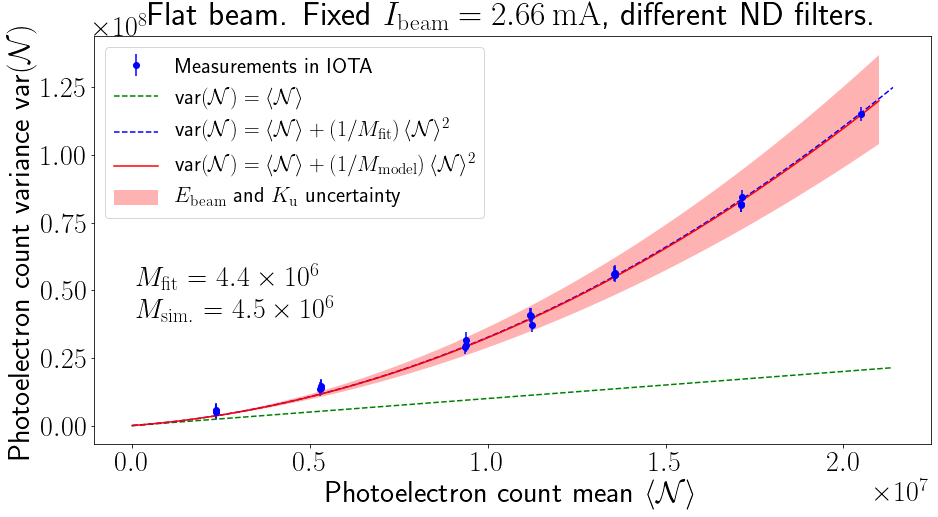

In [99]:
hybrid_errorbar = 2*hybrid_balance_error*np.absolute(varN)
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
#0.33*5.231532189534264e-09*2*sum_channel_to_photoelectrons**2
from matplotlib import rc
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(N,varN,marker='o',linestyle='None',yerr=error_bar,color='b', label = 'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.plot(x_aux, var_theor(x_aux, Mfit),color='blue', linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/M_{\mathrm{fit}}\right)\langle\mathcal{N}\rangle^2$")
ax.plot(theor_df['N'], theor_df['varN'],color='red',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/M_{\mathrm{model}}\right)\langle\mathcal{N}\rangle^2$")
ax.fill_between(
    theor_df['N'],
    theor_df['varN_bottom'],
    theor_df['varN_top'],
    facecolor='red', alpha=0.3,
    label=r'$E_{\mathrm{beam}}$ and $K_{\mathrm{u}}$ uncertainty')
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,2,3]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_title(r"Flat beam. Fixed $I_{\mathrm{beam}} = \SI{"+f"{Ibeam:.2f}"+r"}{mA}$, different ND filters.")
ax.text(0.05,0.63-0.25,r"$M_{\mathrm{fit}}$"+" = {:s}".format(as_si(Mfit,1)),transform=ax.transAxes)
ax.text(0.05,0.55-0.25,r'$M_{\mathrm{sim.}}$'+' = {:s}'\
        .format(as_si(M0,1)),transform=ax.transAxes)
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
#plt.savefig('/home/ilobach/FUR_Run2_experiment_paper/images/flat_nd.png',bbox_inches='tight',dpi=300)
plt.show()

In [21]:
# import fur.path_assistant as path_assistant
# shift = path_assistant.PathAssistant(
#     'shift_03_10_2020',
#     ignore_files=["RefCurve_2020-03-10_0_111937_test.Wfm.bin"])

In [22]:
meas_df = pd.DataFrame({'N': N, 'varN': varN, 'errorbar': error_bar})
meas_df.to_csv(shift.get_results_dir().fi('meas_FLAT_ND_FILTERS_03_10_2020.csv'))

In [23]:
# theor_df = pd.DataFrame({'N': x_aux, 'varN': var_theor(x_aux, M), 'varN_fit': var_theor(x_aux, Mfit),
#                          'varN_top_no_Ebeam': var_theor(x_aux, M-M_std),
#                          'varN_bottom_no_Ebeam': var_theor(x_aux, M+M_std),
#                          'varN_top_with_Ebeam': var_theor(x_aux, M-M_std_with_en),
#                          'varN_bottom_with_Ebeam': var_theor(x_aux, M+M_std_with_en)})
# theor_df['M'] = M
# theor_df['Mfit'] = Mfit
# theor_df.to_csv(shift.get_results_dir().fi('theor_FLAT_ND_FILTERS_03_10_2020.csv'))

In [24]:
ey

0.008972182080293064

# Finding $\epsilon_y$

In [51]:
observed_M = js10.get("observed_M")
Merr = js10.get("M_err")
# from shift_03_16_2020/round_and_round_long_plots/ROUND_with_M_calculation_with_beam_divergence_comparision_with_no_divergence_no_Ku_error.ipynb
tol0 = 0.00001
a0 = 0.005
b0 = 0.025

In [52]:
def bisection_method(func, M, a=a0, b=b0, tol=tol0):
    f = lambda x: func(x) - M
    if f(a)*f(b) > 0:
        #end function, no root.
        print("No root found.")
    else:
        midpoint = (a + b)/2.0
        while (b - a)/2.0 > tol:
            midpoint = (a + b)/2.0
            if f(midpoint) == 0:
                return(midpoint) #The midpoint is the x-intercept/root.
            elif f(a)*f(midpoint) < 0: # Increasing but below 0 case
                b = midpoint
            else:
                a = midpoint
            print(midpoint)
    return midpoint

## with beam divergence

In [27]:
E_in, K_peak_in = EK_list[0]
gamma_in = E_in/0.511
wr_sim, spect = generate_wr_sim_with_wigrad_results_and_spectral_transmission(
K_peak_in=K_peak_in,
gamma_in=gamma_in)
ampx3d = wr_sim.get_amplittude_3D(polarization='x')
mesh = get_from_config("radiation_mesh")
zobs = get_from_config("z_obs_m")
xmin, xmax, _ = mesh[0]
xmin = xmin/zobs
xmax = xmax/zobs
ymin, ymax, _ = mesh[1]
ymin = ymin/zobs
ymax = ymax/zobs
lmin, lmax, _ = mesh[2]
dax = (xmax-xmin)/(mesh[0][2]-1)
day = (ymax-ymin)/(mesh[1][2]-1)
dl = (lmax-lmin)/(mesh[2][2]-1)
elliptic_aperture = \
    (wr_sim.x_3D**2/xmax**2+wr_sim.y_3D**2/ymax**2) < 1
sm =dax*day*dl*np.sum(
    spect[:,None,None]*np.absolute(ampx3d*elliptic_aperture)**2)

In [53]:
def f1(ey):
    Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
        lattice_df,ex,ey,dpp)
    coh_modes_cpp_args =  np.asarray([Sx,Sy,dx,dy,sxp,syp,xmin,xmax,ymin,ymax,lmin,lmax,
                                      st, sm, m0,mfold,seed],
                                    dtype=np.float64)
    Mtmp = np.real(
        cm.CalcMFromPrecalculatedFieldAmps(ampx3d,spect,coh_modes_cpp_args)[-1])
    return Mtmp

ey_with_div = bisection_method(f1, observed_M)

0.015000000000000001
0.01
0.0075
0.00875
0.009375000000000001
0.009062500000000001
0.008906250000000001
0.008828125000000001
0.008867187500000002
0.008847656250000002


In [54]:
ey_with_div_bottom = bisection_method(f1, observed_M-Merr)

0.015000000000000001
0.01
0.0075
0.00875
0.008125
0.0084375
0.00859375
0.008671875
0.0086328125
0.00861328125


In [55]:
ey_with_div_top = bisection_method(f1, observed_M+Merr)

0.015000000000000001
0.01
0.0075
0.00875
0.009375000000000001
0.009062500000000001
0.008906250000000001
0.008984375000000001
0.009023437500000002
0.009042968750000002


In [56]:
js10.save("ey_with_div", ey_with_div)
js10.save("ey_with_div_top", ey_with_div_top-ey_with_div)
js10.save("ey_with_div_bottom", ey_with_div-ey_with_div_bottom)

## without beam divergence

In [57]:
def f2(ey):
    Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
        lattice_df,ex,ey,dpp)
    sx = np.sqrt(Sx**2+sxp**2*dx**2)
    sy = np.sqrt(Sy**2+syp**2*dy**2)
    Sx, Sy, dx, dy, sxp, syp = sx, sy, 0, 0, 0, 0
    coh_modes_cpp_args =  np.asarray([Sx,Sy,dx,dy,sxp,syp,xmin,xmax,ymin,ymax,lmin,lmax,
                                      st, sm, m0,mfold,seed],
                                    dtype=np.float64)
    Mtmp = np.real(
        cm.CalcMFromPrecalculatedFieldAmps(ampx3d,spect,coh_modes_cpp_args)[-1])
    return Mtmp

ey_without_div = bisection_method(f2, observed_M)

0.015000000000000001
0.02
0.0175
0.018750000000000003
0.019375000000000003
0.019062500000000003
0.018906250000000003
0.018984375000000005
0.018945312500000006
0.018925781250000002


In [58]:
ey_without_div_bottom = bisection_method(f2, observed_M-Merr)

0.015000000000000001
0.02
0.0175
0.018750000000000003
0.018125000000000002
0.018437500000000002
0.018593750000000003
0.018515625
0.0185546875
0.018574218750000003


In [59]:
ey_without_div_top = bisection_method(f2, observed_M+Merr)

0.015000000000000001
0.02
0.0175
0.018750000000000003
0.019375000000000003
0.019062500000000003
0.019218750000000003
0.019296875000000005
0.019335937500000004
0.019316406250000005


In [60]:
js10.save("ey_without_div", ey_without_div)
js10.save("ey_without_div_top", ey_without_div_top-ey_without_div)
js10.save("ey_without_div_bottom", ey_without_div-ey_without_div_bottom)